In [1]:
%config InlineBackend.figure_format = 'retina'
import datetime as dt
import sqlite3

import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd

In [2]:
nest_asyncio.apply()

In [3]:
import stan

In [4]:
pd.set_option("display.max_columns", None)

In [5]:
conn = sqlite3.connect("database.sqlite")
# query = """
# SELECT
#   ascent.*
# , grade.*
# , method.score AS method_score
# , method.shorthand AS method_shorthand
# , method.name AS method_name
# , user.*
# FROM ascent
# JOIN grade ON grade.id = ascent.grade_id
# JOIN method ON method.id = ascent.method_id
# JOIN user ON user.id = ascent.user_id
# """
ascents = pd.read_sql_query("SELECT * FROM ascent", conn)
grade = pd.read_sql_query("SELECT * FROM grade", conn)
method = pd.read_sql_query("SELECT * FROM method", conn)
user = pd.read_sql_query("SELECT * FROM user", conn)

In [84]:
df = pd.merge(
    ascents[
        [
            "user_id",
            "grade_id",
            "method_id",
            "date",
            "year",
            "name",
            "crag",
            "rating",
            "country",
            "climb_type",
        ]
    ],
    grade[["id", "fra_routes", "usa_routes"]],
    left_on="grade_id",
    right_on="id",
)
df = pd.merge(
    df,
    user[["id", "country", "sex", "height", "weight", "started", "birth"]],
    left_on="user_id",
    right_on="id",
    suffixes=("_ascent", "_user"),
)
df = pd.merge(
    df,
    method.assign(method_name=lambda x: x.name)[["id", "method_name"]],
    left_on="method_id",
    right_on="id",
)

In [85]:
df = df.rename(columns={"name": "route_name"})

In [86]:
df.head()

,user_id,grade_id,method_id,date,year,route_name,crag,rating,country_ascent,climb_type,id_ascent,fra_routes,usa_routes,id_user,country_user,sex,height,weight,started,birth,id,method_name
0,1,36,3,918342000,1999,The King And I,Railay,0,THA,0,36,6a,5.10a,1,SWE,0,177,73,1996,1976-03-10,3,Onsight
1,1,36,3,925509600,1999,vet ej,Nya berg - segl.,0,,0,36,6a,5.10a,1,SWE,0,177,73,1996,1976-03-10,3,Onsight
2,1,36,3,933026400,1999,Mr Big,Sjöända,0,SWE,0,36,6a,5.10a,1,SWE,0,177,73,1996,1976-03-10,3,Onsight
3,1,36,3,933026400,1999,Tak ska du ha,Sjöända,0,SWE,0,36,6a,5.10a,1,SWE,0,177,73,1996,1976-03-10,3,Onsight
4,1,36,3,933458400,1999,Korpen flyger,"Rankulla, Vetlanda",0,,0,36,6a,5.10a,1,SWE,0,177,73,1996,1976-03-10,3,Onsight


In [9]:
# Derived columns
df["birth_timestamp"] = pd.to_datetime(pd.to_datetime(df["birth"], errors="coerce"))
df["ascent_date"] = pd.to_datetime(df["date"], unit="s")
df["ascent_age"] = (
    (
        (df["ascent_date"] - df["birth_timestamp"]).dt.total_seconds()
        / (365 * 24 * 60 * 60)
    )
    .round()
    .astype("Int32")
)
df["route_id"] = (
    df["crag"].str.lower().str.replace(" ", "_")
    + "__"
    + df["route_name"].str.lower().str.replace(" ", "_")
)

In [10]:
route_cats = pd.CategoricalDtype(
    categories=[
        "5.1",
        "5.2" "5.3",
        "5.4",
        "5.5",
        "5.6",
        "5.7",
        "5.8",
        "5.9",
        "5.10a",
        "5.10b",
        "5.10c",
        "5.10d",
        "5.11a",
        "5.11b",
        "5.11c",
        "5.11d",
        "5.12a",
        "5.12b",
        "5.12c",
        "5.12d",
        "5.13a",
        "5.13b",
        "5.13c",
        "5.13d",
        "5.14a",
        "5.14b",
        "5.14b/c",
        "5.14c",
        "5.14c/d",
        "5.14d",
        "5.15a",
        "5.15b",
        "5.15c",
    ],
    ordered=True,
)

In [11]:
df["usa_routes"] = df["usa_routes"].astype(route_cats)

In [12]:
# Oh, and let's drop duplicates
df = df.drop_duplicates()

In [13]:
# Looks like climb_type = 0 corresponds to routes and 1 is bouldering.
# Limit to just routes.
df = df[df["climb_type"] == 0]

In [14]:
# Let's throw out a bunch of data to calculate some age-related things
MIN_AGE = 10
MAX_AGE = 80
mask = df["birth_timestamp"].notna()
mask &= df["ascent_date"].notna()
mask &= df["ascent_age"] >= 10
mask &= df["ascent_age"] <= 80
num_masked = mask.sum()
print(
    f"Dropping {len(df) - num_masked:,}/{len(df):,} ({1 - num_masked/len(df):.2%}) ascents due to weird dates"
)
clean_age = df[mask]

Dropping 667,449/2,862,784 (23.31%) ascents due to weird dates


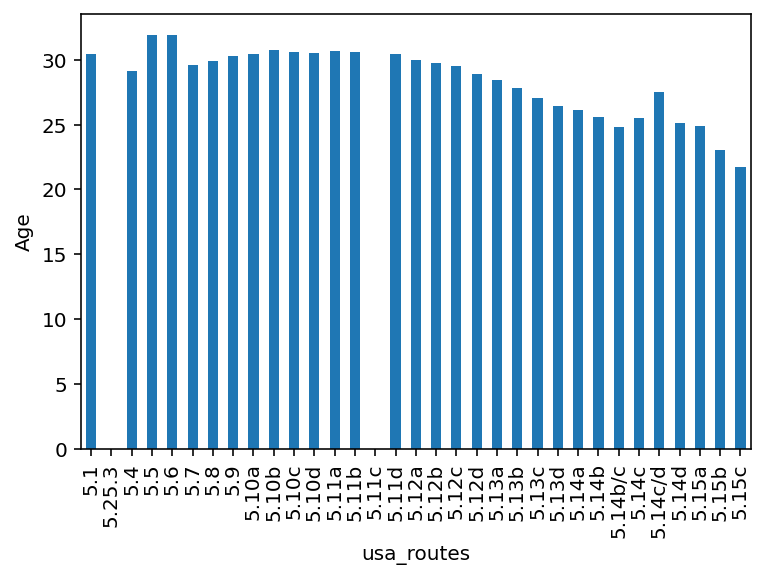

In [15]:
ax = clean_age.groupby("usa_routes")["ascent_age"].mean().plot(kind="bar")
ax.set_ylabel("Age")
None

In [16]:
df["method_name"].value_counts()

Redpoint    1314950
Onsight     1161320
Flash        323137
Toprope       63377
Name: method_name, dtype: int64

Ok to start, we need, at a minimum, user_id, grade_id, and label. Label is +1 if Flash or Onsight. Label is -1 if Redpoint. Also, let's throw out anybody or any grade with fewer than 5 labels. 

In [17]:
df["label"] = df["method_name"].isin(["Onsight", "Flash"])

In [18]:
df["label"].mean()

0.5185361522210548

In [19]:
# Let's just keep the first ascent
first_ascents = df.groupby(["user_id", "route_id"])["ascent_date"].min().to_frame()

In [20]:
print(f"Total ascents: {len(df):,}")
df = pd.merge(df, first_ascents, on=["user_id", "route_id", "ascent_date"])
# This is a bit lazy -- I have no idea what "first" mean in this context
df = df.drop_duplicates(subset=["user_id", "route_id"], keep="first")
print(f"First ascents: {len(df):,}")

Total ascents: 2,862,784
First ascents: 2,755,866


In [21]:
def threshold_ascents(df: pd.DataFrame, limit: int = 5) -> pd.DataFrame:
    """
    Limit all ascents to only users who have logged >= limit ascents
    and only routes that have >= limit ascents.

    This is an iterative process because limiting the users can then
    change which routes have >= limit ascents. So, this function
    alternates back and forth, limiting users and then limiting routes,
    until both stabilize.
    """
    done = False
    df_lim = df.copy()
    print(f"Start number of ascents: {len(df_lim):,}.")
    while not done:
        start_shape = df_lim.shape

        user_mask = df_lim["user_id"].value_counts() >= limit
        users_to_keep = user_mask[user_mask].index
        df_lim = df_lim[df_lim["user_id"].isin(users_to_keep)]

        route_mask = df_lim["route_id"].value_counts() >= limit
        routes_to_keep = route_mask[route_mask].index
        df_lim = df_lim[df_lim["route_id"].isin(routes_to_keep)]

        end_shape = df_lim.shape
        if start_shape == end_shape:
            done = True
    print(f"End number of ascents: {len(df_lim):,}.")
    return df_lim

In [22]:
top_us_crags = df[df["country_ascent"] == "USA"]["crag"].value_counts().head(20).index
print(top_us_crags)

Index(['Red River Gorge', 'New River Gorge', 'Rifle', 'Red Rocks',
       'Maple Canyon', 'Rumney', 'Smith Rocks', 'Ten sleep', 'American Fork',
       'Obed', 'Clear Creek Canyon', 'Owens River Gorge', 'Wild Iris',
       'Boulder Canyon', 'Little River Canyon', 'Foster falls', 'Shelf Road',
       'Indian creek', 'Horseshoe Canyon Ranch', 'Sinks Canyon'],
      dtype='object')


In [23]:
print(f"Global ascents: {len(df):,}")
df_lim = df[df["crag"].isin(top_us_crags)]
print(f"Acents from Top-20 US Crags: {len(df_lim):,}")

Global ascents: 2,755,866
Acents from Top-20 US Crags: 178,542


In [24]:
df_lim = threshold_ascents(df_lim, limit=20)

Start number of ascents: 178,542.
End number of ascents: 96,824.


In [25]:
# # Let's severely downsample the data
# sampled_routes = np.random.choice(df_lim["route_name"].unique(), 2_500)
# df_lim = df_lim[df_lim["route_name"].isin(sampled_routes)]

In [26]:
# df_lim = threshold_ascents(df_lim, limit=5)

In [27]:
# Throw out climbs with out USA route ratings (this could include bouldering routes)
df_lim = df_lim[df_lim["usa_routes"].notna()]
print(f"Routes with Yosemite ratings: {len(df_lim):,}")

Routes with Yosemite ratings: 96,823


In [28]:
df_lim.head()

,user_id,grade_id,method_id,date,year,route_name,crag,rating,country_ascent,climb_type,id_ascent,fra_routes,usa_routes,id_user,country_user,sex,height,weight,started,birth,id,method_name,birth_timestamp,ascent_date,ascent_age,route_id,label
741,38,55,3,1347487200,2012,Giant Man,Rumney,3,USA,0,55,7b+,5.12c,38,GBR,0,178,73,1993,1982-12-10,3,Onsight,1982-12-10,2012-09-12 22:00:00,30,rumney__giant_man,True
742,38,55,3,1347314400,2012,Restless Native,Rumney,3,USA,0,55,7b+,5.12c,38,GBR,0,178,73,1993,1982-12-10,3,Onsight,1982-12-10,2012-09-10 22:00:00,30,rumney__restless_native,True
752,38,55,3,1466719200,2016,Pretty Hate Machine,Rifle,3,USA,0,55,7b+,5.12c,38,GBR,0,178,73,1993,1982-12-10,3,Onsight,1982-12-10,2016-06-23 22:00:00,34,rifle__pretty_hate_machine,True
754,38,55,3,1466978400,2016,Burnt Beans And Coffee,Wild Iris,0,USA,0,55,7b+,5.12c,38,GBR,0,178,73,1993,1982-12-10,3,Onsight,1982-12-10,2016-06-26 22:00:00,34,wild_iris__burnt_beans_and_coffee,True
798,38,57,3,1347400800,2012,Man Overboard,Rumney,3,USA,0,57,7c,5.12d,38,GBR,0,178,73,1993,1982-12-10,3,Onsight,1982-12-10,2012-09-11 22:00:00,30,rumney__man_overboard,True


In [29]:
assert df_lim["route_id"].isna().sum() == 0
assert df_lim["user_id"].isna().sum() == 0
assert df_lim["label"].isna().sum() == 0

In [30]:
# Start IDs at 1 so they match stan
route_idx_to_id = dict(enumerate(df_lim["route_id"].unique(), start=1))
route_id_to_idx = {v: k for k, v in route_idx_to_id.items()}

user_idx_to_id = dict(enumerate(df_lim["user_id"].unique(), start=1))
user_id_to_idx = {v: k for k, v in user_idx_to_id.items()}

routes = df_lim["route_id"].map(route_id_to_idx).values.astype(int)
users = df_lim["user_id"].map(user_id_to_idx).values.astype(int)
labels = df_lim["label"].values.astype(int)

In [31]:
stan_code = """
data {
    int<lower=1> num_ascents;
    int<lower=1> num_users;
    int<lower=1> num_routes;
    int<lower=1, upper=num_routes> routes[num_ascents];
    int<lower=1, upper=num_users> users[num_ascents];
    int<lower=0, upper=1> labels[num_ascents];    
}
parameters {
    real mean_ability; 
    real user_ability[num_users]; // user_ability - mean_ability
    real route_difficulty[num_routes];
}
model {
    user_ability ~ std_normal();
    route_difficulty ~ std_normal();
    mean_ability ~ std_normal();
    for (a in 1:num_ascents)
        labels[a] ~ bernoulli_logit(
            user_ability[users[a]] - route_difficulty[routes[a]] + mean_ability
        );
}
"""

In [32]:
stan_data = {
    "num_ascents": len(users),
    "num_users": users.max(),
    "num_routes": routes.max(),
    "routes": routes,
    "users": users,
    "labels": labels,
}

In [33]:
print(f"Num Users: {stan_data['num_users']:,}")
print(f"Num Routes: {stan_data['num_routes']:,}")

Num Users: 1,454
Num Routes: 1,756


In [34]:
posterior = stan.build(stan_code, data=stan_data, random_seed=666)

Building: found in cache, done.


In [35]:
fit = posterior.sample(num_chains=4, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [36]:
fit_df = fit.to_frame()

In [37]:
print(fit)

<stan.Fit>
Parameters:
    mean_ability: ()
    user_ability: (1454,)
    route_difficulty: (1756,)
Draws: 4000


In [38]:
import arviz as az

In [39]:
dataset = az.convert_to_dataset(fit)

In [40]:
fit_df.to_pickle("fit_df.pkl")

In [41]:
dataset.to_netcdf("fit_dataset.nc")

In [42]:
df_lim.to_pickle("df_lim.pkl")

In [43]:
import pickle

with open("route_idx_to_id.pkl", "wb") as f:
    pickle.dump(route_idx_to_id, f)

In [44]:
# https://arviz-devs.github.io/arviz/user_guide/pystan_refitting.html

In [45]:
summary = az.summary(dataset, fmt="xarray")

In [46]:
summary.head()

<xarray.Dataset>
Dimensions:                 (metric: 5, user_ability_dim_0: 5,
                             route_difficulty_dim_0: 5)
Coordinates:
  * user_ability_dim_0      (user_ability_dim_0) int64 0 1 2 3 4
  * route_difficulty_dim_0  (route_difficulty_dim_0) int64 0 1 2 3 4
  * metric                  (metric) <U9 'mean' 'sd' ... 'hdi_97%' 'mcse_mean'
Data variables:
    mean_ability            (metric) float64 -0.1531 0.03696 ... 0.00119
    user_ability            (metric, user_ability_dim_0) float64 2.347 ... 0....
    route_difficulty        (metric, route_difficulty_dim_0) float64 0.9207 ....

In [47]:
route_difficulty_inferred = (
    summary["route_difficulty"].to_dataframe().unstack().T["mean"].values
)
user_ability_inferred = (
    summary["user_ability"].to_dataframe().unstack().T["mean"].values
)

In [48]:
summary["route_difficulty"].to_dataframe().unstack().T

metric                                       mean        sd    hdi_3%  \
                 route_difficulty_dim_0                                 
route_difficulty 0                       0.920684  0.295097  0.352619   
                 1                       2.054420  0.340961  1.447040   
                 2                       1.818970  0.219251  1.404751   
                 3                       0.577677  0.306678 -0.003323   
                 4                       1.736322  0.379949  1.034132   
...                                           ...       ...       ...   
                 1751                    3.199850  0.552985  2.219794   
                 1752                    3.184235  0.574917  2.129513   
                 1753                    2.809875  0.563792  1.804252   
                 1754                    1.044980  0.468677  0.197840   
                 1755                    3.220472  0.541792  2.209206   

metric                                    hdi_97%  mcse_mean   mcse_sd  \
                 route_difficulty_dim_0                                  
route_difficulty 0                       1.470488   0.003200  0.002538   
                 1                       2.735655   0.003794  0.002950   
                 2                       2.224818   0.002328  0.001715   
                 3                       1.134712   0.002886  0.002806   
                 4                       2.475149   0.003574  0.002824   
...                                           ...        ...       ...   
                 1751                    4.253876   0.005641  0.004351   
                 1752                    4.264215   0.006131  0.004809   
                 1753                    3.928373   0.006260  0.005016   
                 1754                    1.978093   0.004884  0.004812   
                 1755                    4.217605   0.006142  0.004712   

metric                                       ess_bulk     ess_tail     r_hat  
                 route_difficulty_dim_0                                       
route_difficulty 0                        8541.099847  2692.074681  1.002767  
                 1                        8242.214792  2544.194680  1.001880  
                 2                        8955.540361  2709.226132  0.999822  
                 3                       11174.525181  2635.618725  1.001088  
                 4                       11333.194966  2834.228903  1.003421  
...                                               ...          ...       ...  
                 1751                    10020.290038  2822.807111  1.000611  
                 1752                     9213.872935  2485.743244  0.999567  
                 1753                     8542.695387  2591.538340  1.002437  
                 1754                     9505.036776  2644.732301  1.002312  
                 1755                     8073.565619  2490.627591  1.000309  

[1756 rows x 9 columns]

Does the inferred difficulty of the climb scale with the route grade? Looks like yes, although there's a wide span.

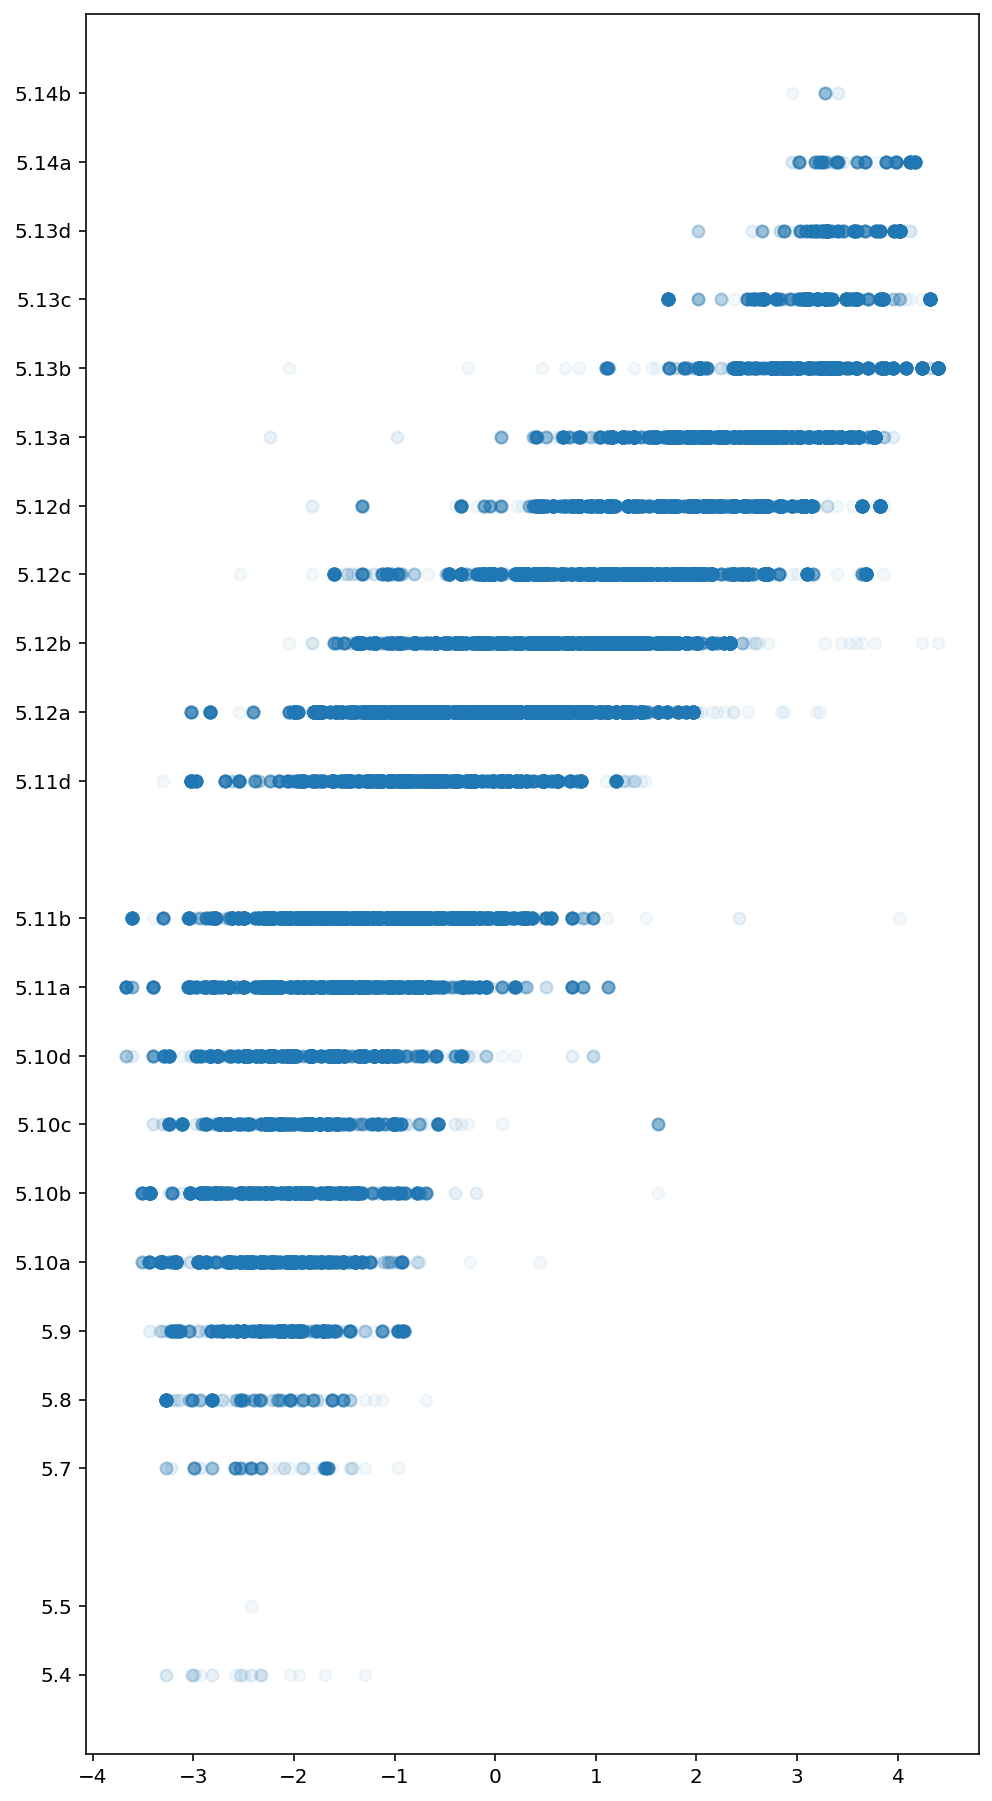

In [49]:
# God this is a mess trying to deal with the categorical columns.
# Basic idea is that some categories are actually not present in this limited data,
# So we have to remove them as options from the Categorical dtype.

fig, ax = plt.subplots(figsize=(8, 16))
# ax.invert_yaxis()
mask = df_lim["usa_routes"].notna()
ax.scatter(
    y=df_lim[mask]["usa_routes"].cat.codes.values,
    x=route_difficulty_inferred[routes - 1][mask],
    alpha=0.05,
)
ax.set_yticks(sorted(np.unique(df_lim[mask]["usa_routes"].values.codes)))
ax.set_yticklabels(
    df_lim[mask]["usa_routes"].cat.remove_unused_categories().values.categories.values
)
None

Does climber ability scale with the difficulty of the climb? Not really.

In [50]:
five_12_cs = df_lim.loc[df_lim["usa_routes"] == "5.12c", "route_id"].unique()
five_12_cs = sorted([route_id_to_idx[route] for route in five_12_cs])

five_12_as = df_lim.loc[df_lim["usa_routes"] == "5.12a", "route_id"].unique()
five_12_as = sorted([route_id_to_idx[route] for route in five_12_as])

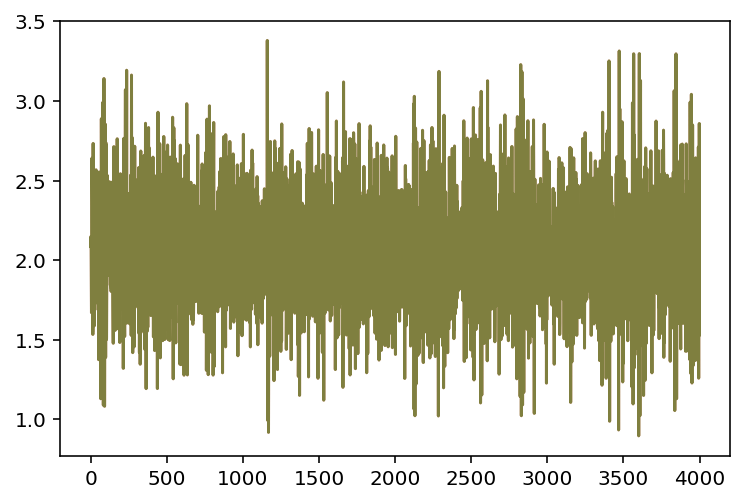

In [51]:
plt.plot(fit["route_difficulty"][five_12_cs][0, :], "r-", alpha=0.5)
plt.plot(fit["route_difficulty"][five_12_as][0, :], "g-", alpha=0.5);

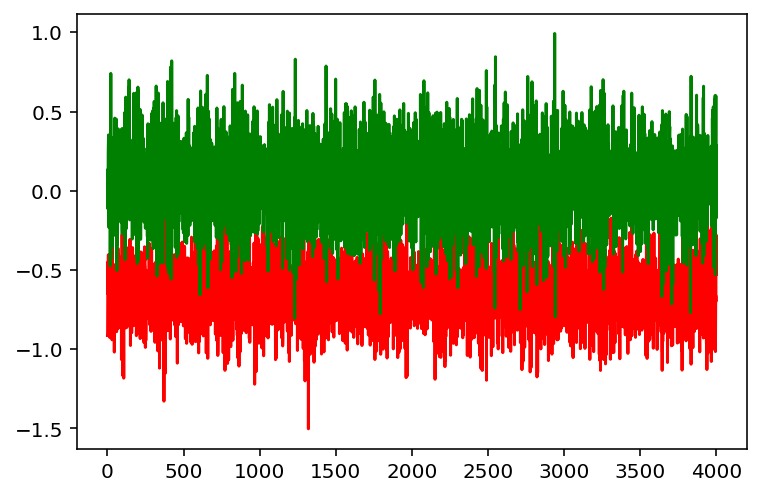

In [52]:
plt.plot(fit["route_difficulty"][five_12_cs][10, :], "r-")
plt.plot(fit["route_difficulty"][five_12_as][10, :], "g-");

<AxesSubplot:ylabel='Density'>

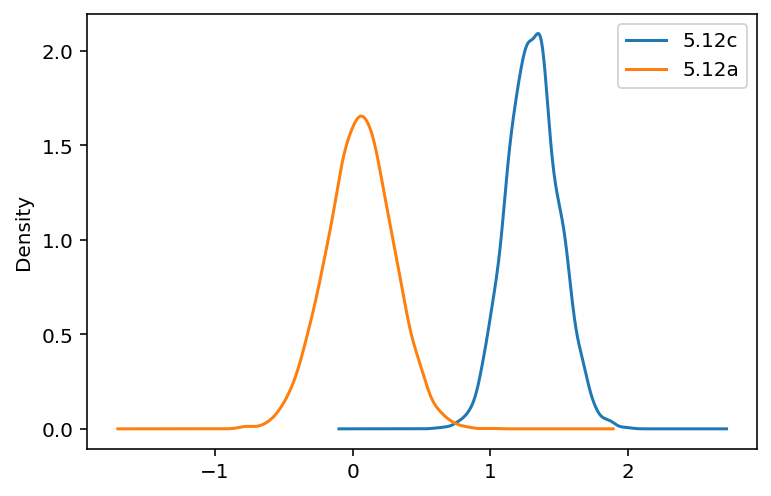

In [53]:
ax = pd.DataFrame(
    fit["route_difficulty"][five_12_cs][13, :], columns=["5.12c"]
).plot.kde()
pd.DataFrame(fit["route_difficulty"][five_12_as][10, :], columns=["5.12a"]).plot.kde(
    ax=ax
)

In [54]:
import cycler

In [55]:
from scipy.stats import gaussian_kde

There are no 5.11c climbs for some reason that I don't understand.

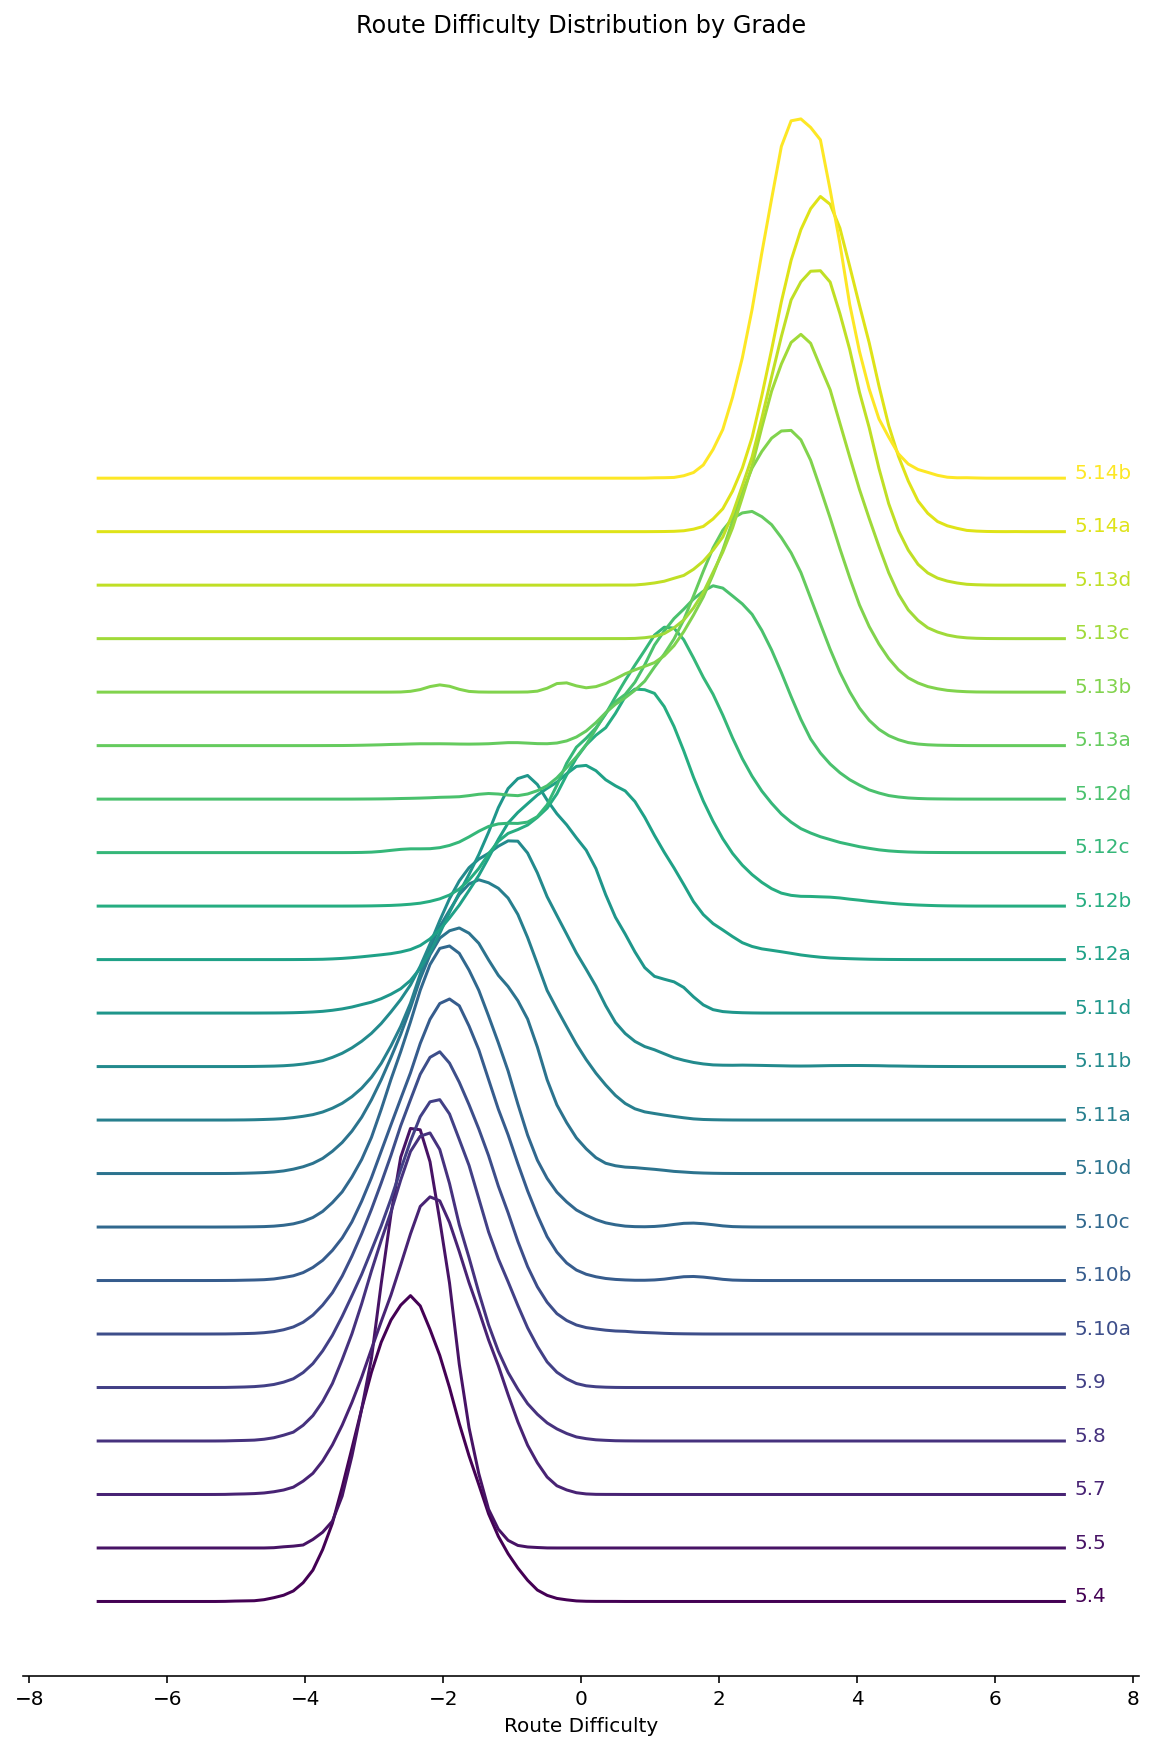

In [56]:
fig, ax = plt.subplots(figsize=(10, 15))

difficulties = df_lim["usa_routes"].cat.remove_unused_categories().values.categories
color_map = plt.cm.viridis(np.linspace(0, 1, len(difficulties)))
ax.set_prop_cycle(cycler.cycler("color", color_map))
total_offset = 0
delta = 0.1
num_points = 100
points = np.linspace(-7, 7, num_points)
xmax = 0.0
for difficulty, color in zip(difficulties, color_map):
    these_routes = df_lim.loc[df_lim["usa_routes"] == difficulty, "route_id"].unique()

    these_routes = [
        # Subtract 1 to convert from Stan-based 1-indexing to Python-based 0-indexing
        route_id_to_idx[route] - 1
        for route in these_routes
    ]
    if these_routes:
        these_difficulties = fit["route_difficulty"][these_routes].ravel()
        kernel = gaussian_kde(these_difficulties)
        density = kernel(points)
        ax.plot(points, density + total_offset, color=color, label=difficulty)
        x, y = (points[-1], (density + total_offset)[-1])
        ax.annotate(difficulty, xy=(x, y), xytext=(1.02 * x, y), color=color)
        #         ax.legend()
        total_offset += delta
xlim = ax.get_xlim()
ax.set_xlim(xlim[0] * 1.05, xlim[1] * 1.05)
ax.set_xlabel("Route Difficulty")
ax.set_title("Route Difficulty Distribution by Grade")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_yticks([])
ax.set_yticks([], minor=True)
None

In [57]:
five_11_as = df_lim.loc[df_lim["usa_routes"] == "5.11a", "route_id"].unique()
# Offset by 1 to be able to zero-based index
five_11_as = sorted([route_id_to_idx[route] - 1 for route in five_11_as])

In [58]:
mean_route_difficulty = (
    summary["route_difficulty"]
    .to_dataframe()
    .unstack()
    .T.reset_index(level=0)
    .sort_index()["mean"]
)

In [59]:
mean_route_difficulty

route_difficulty_dim_0
0       0.920684
1       2.054420
2       1.818970
3       0.577677
4       1.736322
          ...   
1751    3.199850
1752    3.184235
1753    2.809875
1754    1.044980
1755    3.220472
Name: mean, Length: 1756, dtype: float64

Max difficulty
red_rocks__nirvana


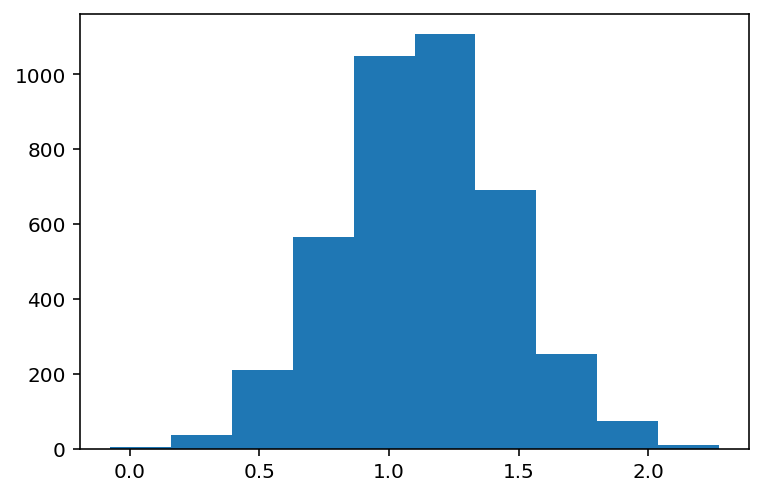

In [67]:
these_difficulties = mean_route_difficulty.loc[five_11_as]
max_difficult_route_idx = these_difficulties.index[these_difficulties.argmax()]
plt.hist(fit["route_difficulty"][max_difficult_route_idx])

# Offset by 1 to match route_idx
print("Max difficulty")
print(route_idx_to_id[max_difficult_route_idx + 1])

Min difficulty
ten_sleep__crossbow_chaos_theory


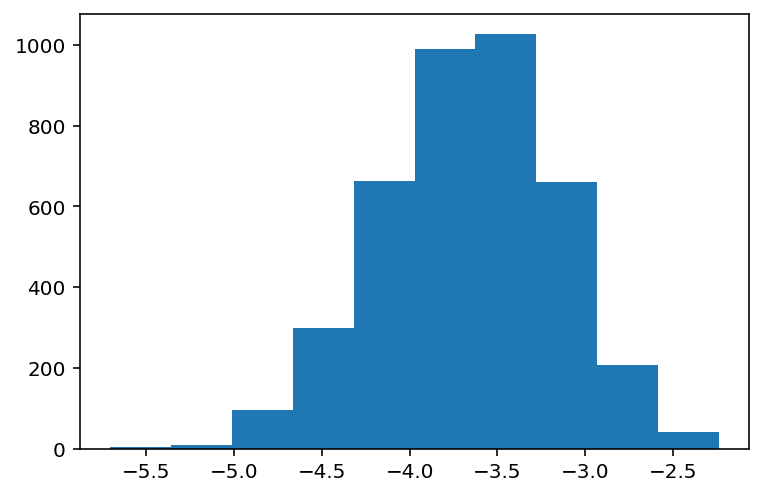

In [68]:
# Need to figure out the indexing here.
these_difficulties = mean_route_difficulty.loc[five_11_as]
min_difficult_route_idx = these_difficulties.index[these_difficulties.argmin()]
plt.hist(fit["route_difficulty"][min_difficult_route_idx])

# Offset by 1 to match route_idx
print("Min difficulty")
print(route_idx_to_id[min_difficult_route_idx + 1])

In [63]:
# Offset by 1 to match route_idx
route_idx_to_id[max_difficult_route_idx + 1]

'red_rocks__nirvana'

In [75]:
# Best climber
mean_user_ability = (
    summary["user_ability"]
    .to_dataframe()
    .unstack()
    .T.reset_index(level=0)
    .sort_index()["mean"]
)
top_user = user_idx_to_id[mean_user_ability.index[mean_user_ability.argmax()] + 1]

In [77]:
user.query(f"id == {top_user}")

,id,first_name,last_name,city,country,sex,height,weight,started,competitions,occupation,sponsor1,sponsor2,sponsor3,best_area,worst_area,guide_area,interests,birth,presentation,deactivated,anonymous
11445,11956,first,last,Bolzano,ITA,0,176,63,2001,,"student, routesetter",The North Face,"Smith Optics, Petzl, Mountain Spirit","La Sportiva, Mulebar;",Ceuse,None,,,1989-10-13,http://jacopo-larcher.com,1,0


In [81]:
df.query(f"user_id == {top_user}")

,user_id,grade_id,method_id,date,year,route_name,crag,rating,country_ascent,climb_type,id_ascent,fra_routes,usa_routes,id_user,country_user,sex,height,weight,started,birth,id,method_name,birth_timestamp,ascent_date,ascent_age,route_id,label
999269,11956,42,3,1112738400,2005,Musetto e big gim,Arco,0,ITA,0,42,6b+,5.10d,11956,ITA,0,176,63,2001,1989-10-13,3,Onsight,1989-10-13,2005-04-05 22:00:00,15,arco__musetto_e_big_gim,True
999270,11956,44,3,1113688800,2005,La Cura Della Fessura,Arco,0,ITA,0,44,6c,5.11a,11956,ITA,0,176,63,2001,1989-10-13,3,Onsight,1989-10-13,2005-04-16 22:00:00,16,arco__la_cura_della_fessura,True
999271,11956,44,3,1134255600,2005,Ottopromille,Arco,1,ITA,0,44,6c,5.11a,11956,ITA,0,176,63,2001,1989-10-13,3,Onsight,1989-10-13,2005-12-10 23:00:00,16,arco__ottopromille,True
999272,11956,44,3,1134255600,2005,Ulla,Arco,0,ITA,0,44,6c,5.11a,11956,ITA,0,176,63,2001,1989-10-13,3,Onsight,1989-10-13,2005-12-10 23:00:00,16,arco__ulla,True
999273,11956,44,3,1113688800,2005,il ballatoio,Arco,1,ITA,0,44,6c,5.11a,11956,ITA,0,176,63,2001,1989-10-13,3,Onsight,1989-10-13,2005-04-16 22:00:00,16,arco__il_ballatoio,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669659,11956,59,2,1226098800,2008,Fiasko,Ötztal,1,AUT,0,59,7c+,5.13a,11956,ITA,0,176,63,2001,1989-10-13,2,Flash,1989-10-13,2008-11-07 23:00:00,19,ötztal__fiasko,True
2669660,11956,59,2,1232233200,2009,Golden Boy,Arco,2,ITA,0,59,7c+,5.13a,11956,ITA,0,176,63,2001,1989-10-13,2,Flash,1989-10-13,2009-01-17 23:00:00,19,arco__golden_boy,True
2669661,11956,64,2,1319148000,2011,Roofopoulos,kalymnos,2,GRC,0,64,8a+,5.13c,11956,ITA,0,176,63,2001,1989-10-13,2,Flash,1989-10-13,2011-10-20 22:00:00,22,kalymnos__roofopoulos,True
2669662,11956,68,2,1325199600,2011,Kale borroka,Siurana,3,ESP,0,68,8b+,5.14a,11956,ITA,0,176,63,2001,1989-10-13,2,Flash,1989-10-13,2011-12-29 23:00:00,22,siurana__kale_borroka,True


In [139]:
tmp["usa_boulders_input"].mean()

0.9720319941476848

In [133]:
tmp = tmp[tmp["name"].str.lower() == "feels like grit"]

In [135]:
tmp.tail()

,id_x,user_id,grade_id,notes,raw_notes,method_id,climb_type,total_score,date,year,last_year,rec_date,project_ascent_date,name,crag_id,crag,sector_id,sector,country,comment,rating,description,yellow_id,climb_try,repeat,exclude_from_ranking,user_recommended,chipped,id_y,score,fra_routes,fra_routes_input,fra_routes_selector,fra_boulders,fra_boulders_input,fra_boulders_selector,usa_routes,usa_routes_input,usa_routes_selector,usa_boulders,usa_boulders_input,usa_boulders_selector
3117916,4890585,66936,55,,0,1,1,850,1491775200,2017,1,1504019673,0,Feels Like Grit,22638,Joe's Valley,3730,riverside,USA,,3,,255,0,0,0,0,0,55,850,7b+,1,0,7B+,1,0,5.12c,1,1,V8/9,1,0
3289848,3710062,39596,57,,0,1,1,900,1426287600,2015,0,1426707982,0,Feels Like Grit,22638,Joe's Valley,0,,USA,,3,,255,0,0,0,0,0,57,900,7c,1,1,7C,1,1,5.12d,1,0,V9,1,1
3327310,4529712,60227,57,Hard,16,1,1,900,1478386800,2016,1,1492229008,0,Feels Like Grit,22638,Joe's Valley,0,,USA,"Very hard, felt harder than v8, arête version....",3,,255,0,0,0,1,0,57,900,7c,1,1,7C,1,1,5.12d,1,0,V9,1,1
3555503,1086985,17230,59,,0,1,1,950,1194044400,2007,0,1225745505,0,Feels Like Grit,22638,Joe's Valley,0,,USA,,2,,255,0,0,0,0,0,59,950,7c+,1,0,7C+,1,0,5.13a,1,1,V10,1,0
3677979,3353607,46995,13,,0,1,1,100,1401055200,2014,0,1428727922,0,Feels like grit,22638,Joe's Valley,3730,riverside,USA,choss. did it during a hailstorm naked.,0,,255,0,0,0,1,0,13,100,3a,1,0,3A,1,0,5.3,0,0,VB,0,0


In [65]:
route_idx_to_id[these.iloc[these["mean"].argmax()].name[-1] + 1]

NameError: name 'these' is not defined

In [99]:
# Looks like the same route can have different grades!
df_lim[df_lim["route_name"] == "The Legend"]["usa_routes"].value_counts()

5.13b       95
5.12b        1
5.13c        1
5.12c        0
5.15b        0
5.15a        0
5.14d        0
5.14c/d      0
5.14c        0
5.14b/c      0
5.14b        0
5.14a        0
5.13d        0
5.13a        0
5.12d        0
5.1          0
5.3          0
5.12a        0
5.11d        0
5.11b        0
5.11a        0
5.10d        0
5.10c        0
5.10b        0
5.95.10a     0
5.8          0
5.7          0
5.6          0
5.5          0
5.4          0
5.15c        0
Name: usa_routes, dtype: int64

In [78]:
summary["route_difficulty"].to_dataframe().unstack().T.head()

metric                                       mean        sd    hdi_3%  \
                 route_difficulty_dim_0                                 
route_difficulty 0                      -2.750404  0.267964 -3.272043   
                 1                      -2.612998  0.424579 -3.403927   
                 2                      -1.674680  0.200789 -2.070092   
                 3                      -1.901317  0.218086 -2.303152   
                 4                       0.424674  0.174962  0.086153   

metric                                    hdi_97%  mcse_mean   mcse_sd  \
                 route_difficulty_dim_0                                  
route_difficulty 0                      -2.255629   0.002995  0.002185   
                 1                      -1.818626   0.004263  0.003233   
                 2                      -1.318270   0.002099  0.001502   
                 3                      -1.470127   0.002297  0.001624   
                 4                       0.735175   0.001886  0.001583   

metric                                      ess_bulk     ess_tail     r_hat  
                 route_difficulty_dim_0                                      
route_difficulty 0                       8092.665195  2683.092097  1.000177  
                 1                       9965.400856  2366.621296  1.003957  
                 2                       9111.232302  2889.669763  1.000074  
                 3                       8983.250379  2886.495001  1.000340  
                 4                       8588.444306  3067.560179  1.000936

In [65]:
ascents[ascents["country"] == "USA"]["crag"].value_counts().head(25)

Red River Gorge           51733
Bishop                    44270
Hueco Tanks               30334
Red Rocks                 22420
Joe's Valley              20133
Little Rock City          19650
New River Gorge           18880
Rifle                     14905
Rumney                    13264
Maple Canyon              12482
HP 40                     12207
RMNP                      11491
Rocktown                  10744
Yosemite                  10468
Gunks                      8074
Smith Rocks                8042
Ten sleep                  7460
Leavenworth                6778
Horseshoe Canyon Ranch     6702
Joshua Tree                6597
American Fork              6580
Clear Creek Canyon         5627
Tramway                    5120
Obed                       4971
LCC                        4803
Name: crag, dtype: int64

In [ ]:
###################################################

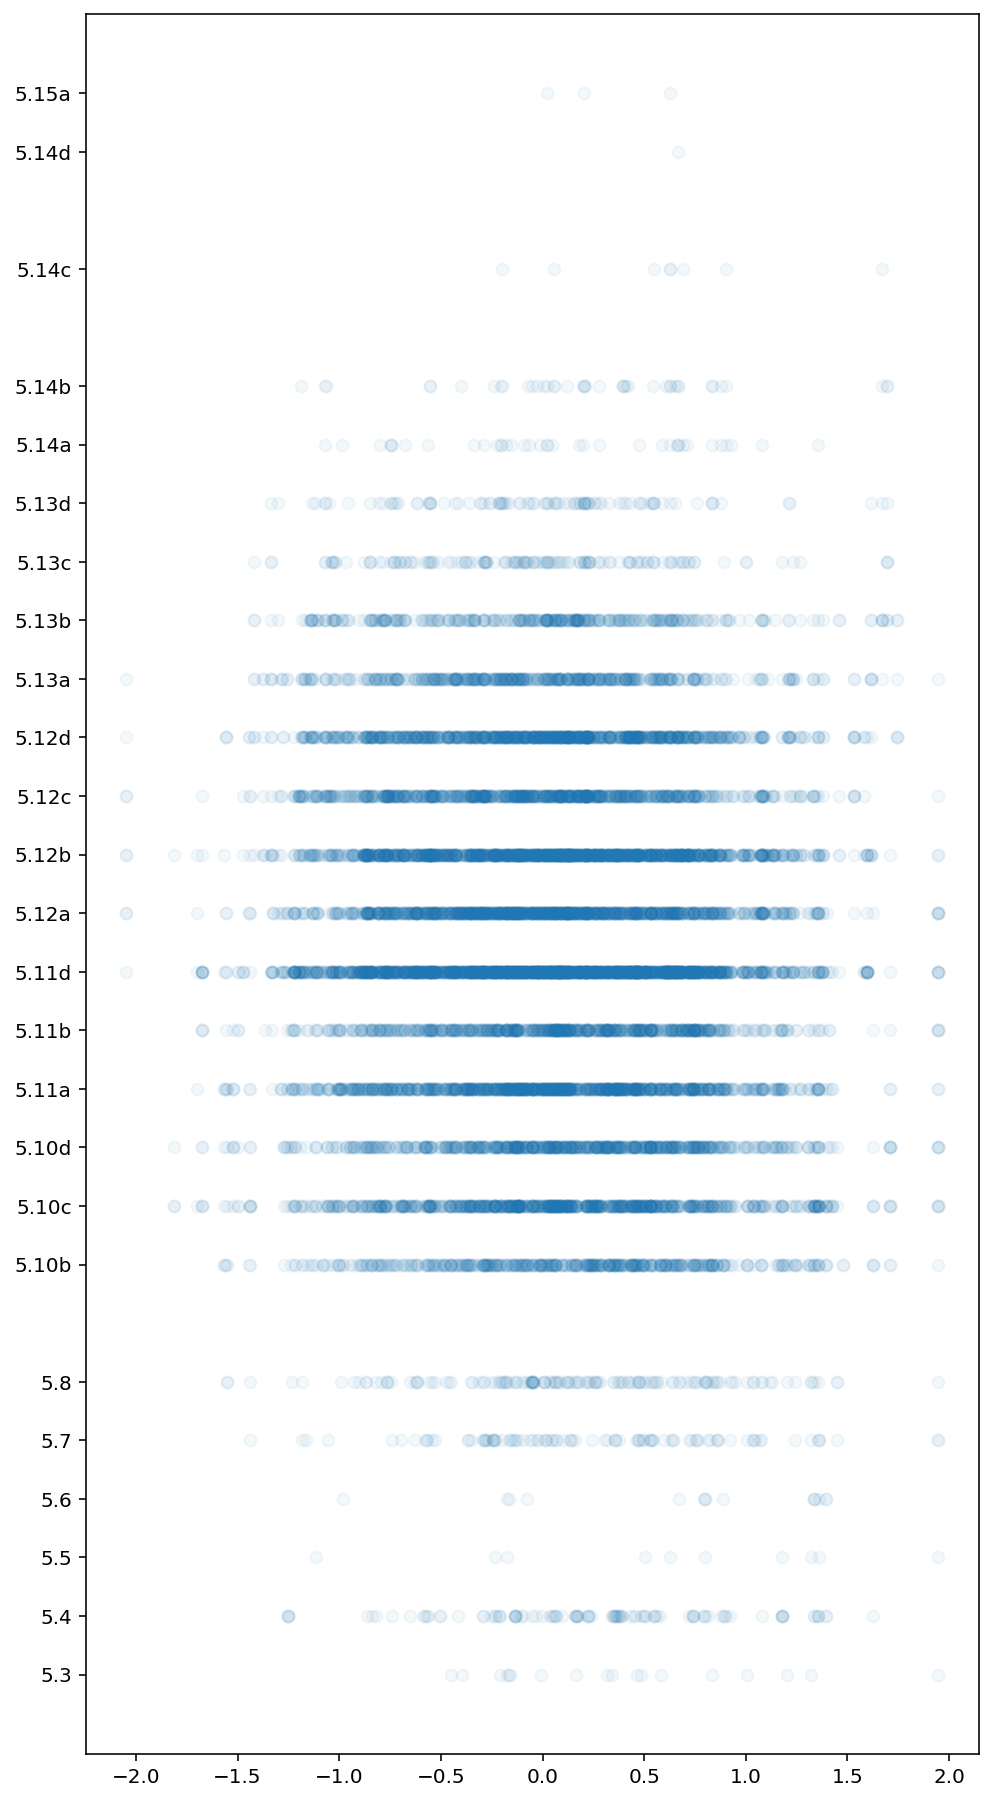

In [152]:
# God this is a mess trying to deal with the categorical columns.
# Basic idea is that some categories are actually not present in this limited data,
# So we have to remove them as options from the Categorical dtype.

fig, ax = plt.subplots(figsize=(8, 16))
# ax.invert_yaxis()
mask = df_lim["usa_routes"].notna()
ax.scatter(
    y=df_lim[mask]["usa_routes"].cat.codes.values,
    x=user_ability_inferred[users - 1][mask],
    alpha=0.05,
)
ax.set_yticks(sorted(np.unique(df_lim[mask]["usa_routes"].values.codes)))
ax.set_yticklabels(
    df_lim[mask]["usa_routes"].cat.remove_unused_categories().values.categories.values
)
None

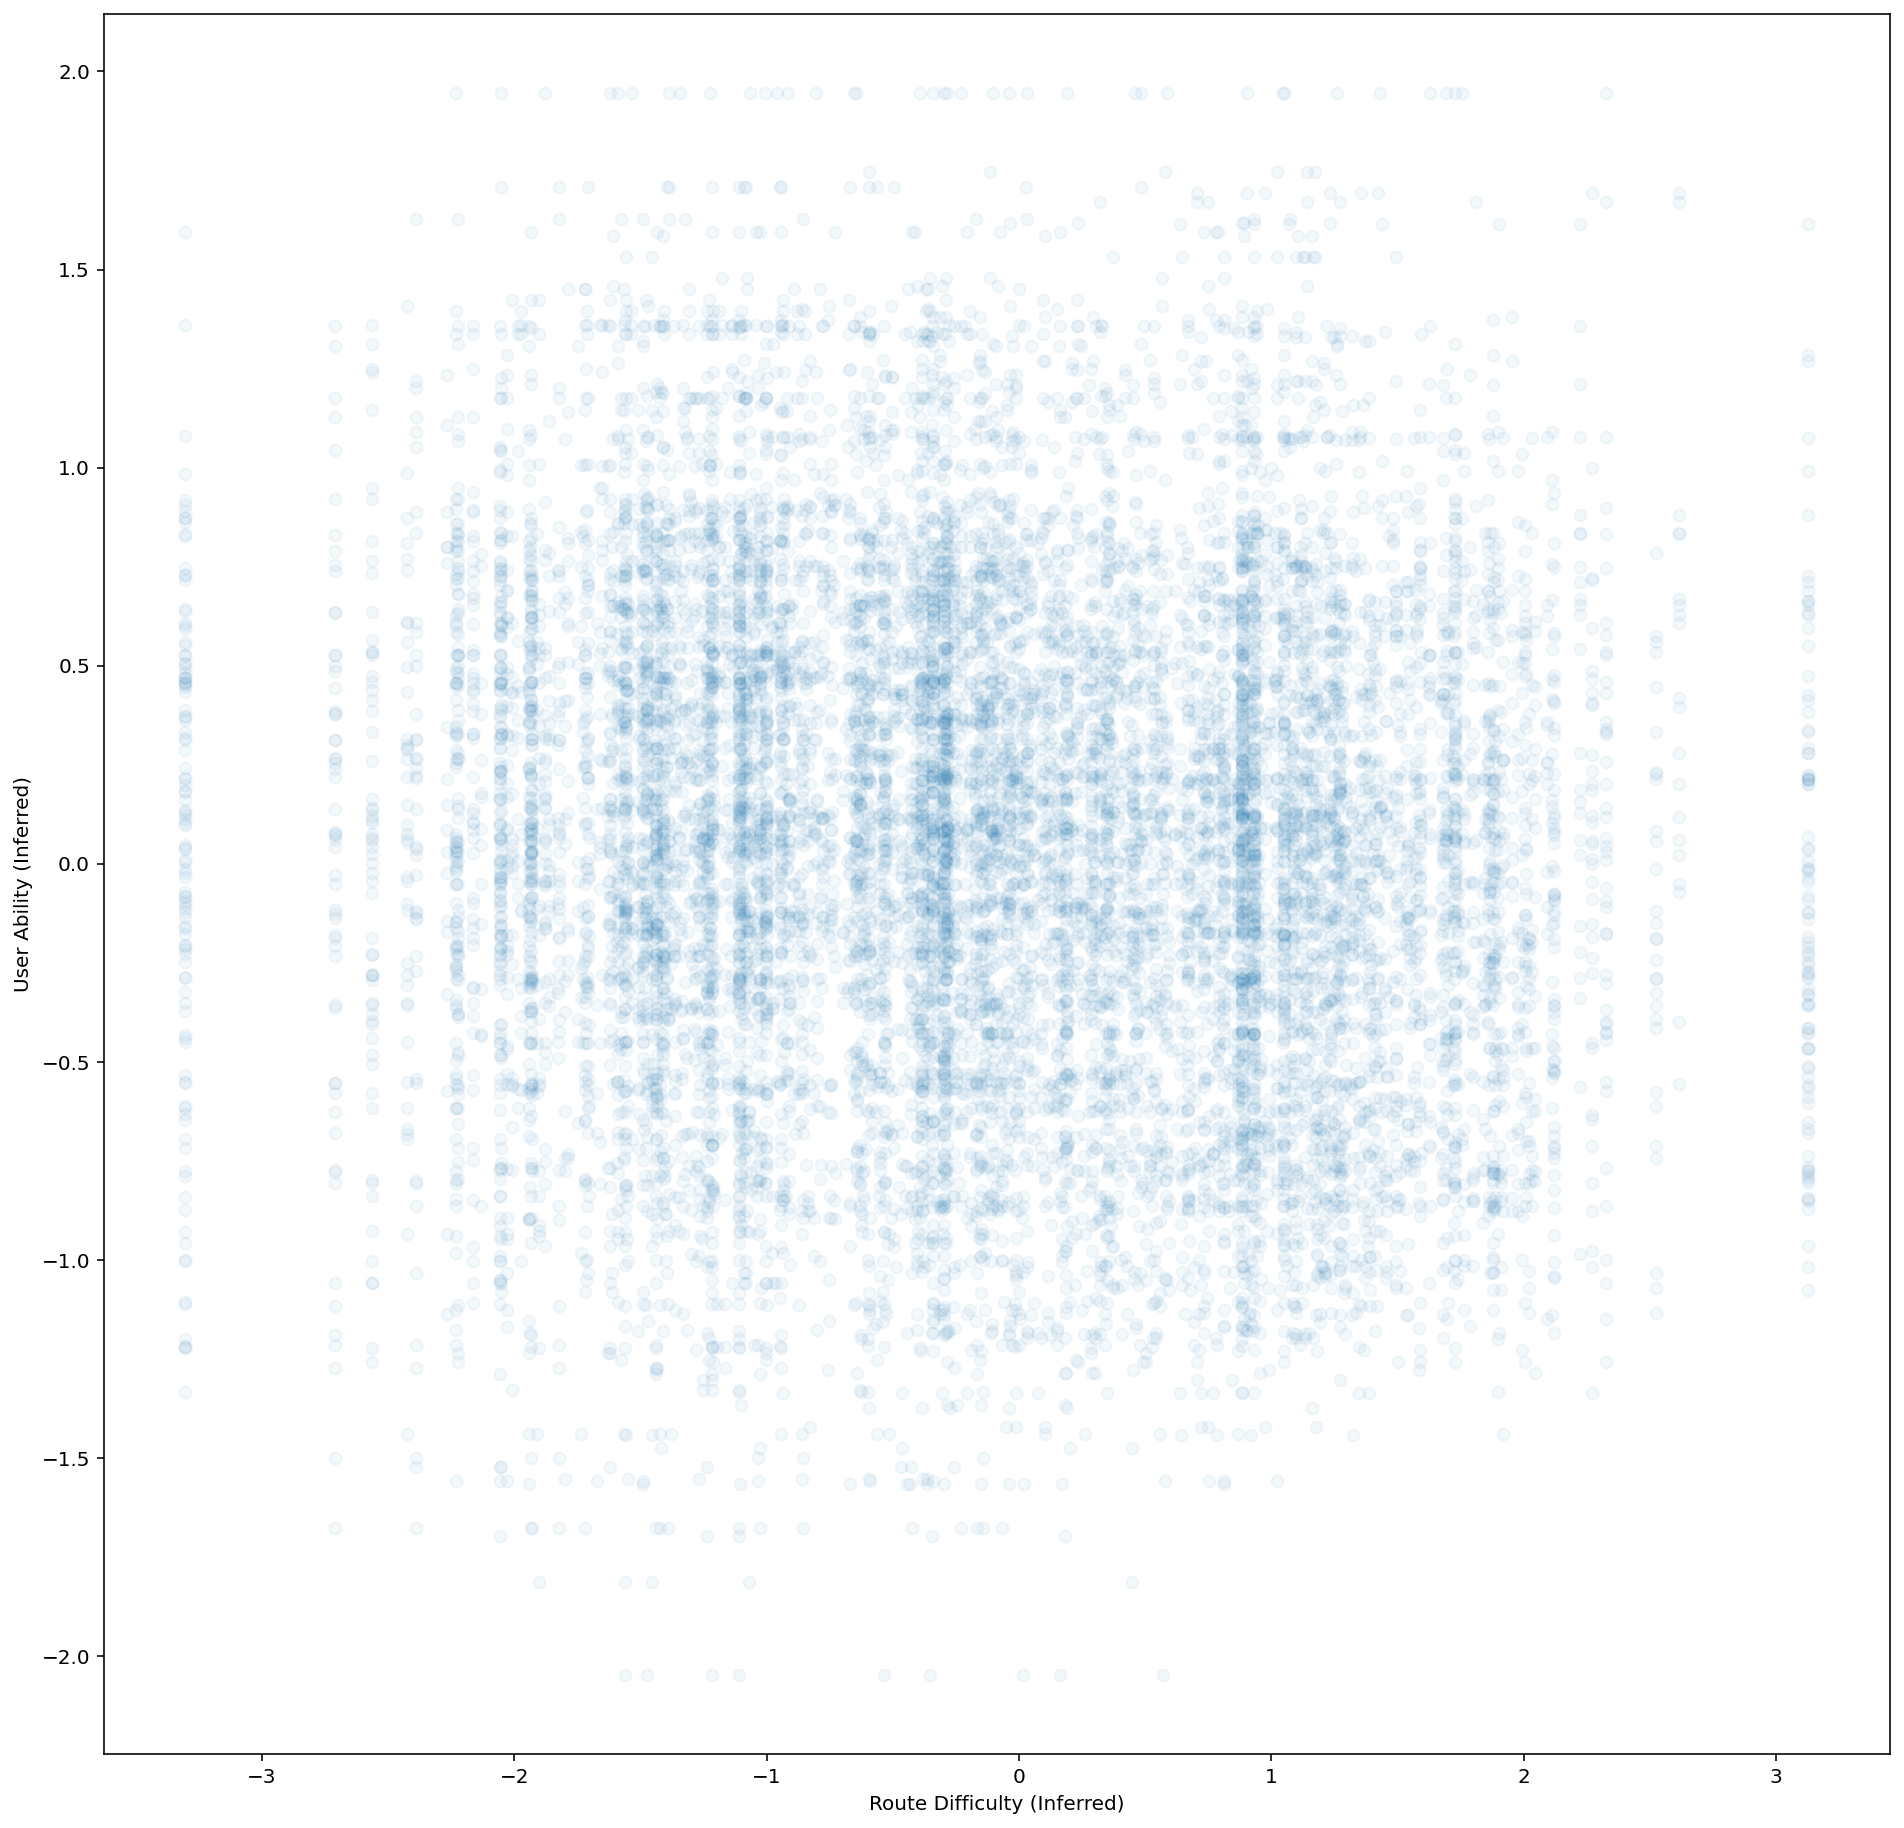

In [155]:
# What about inferred user ability vs. inferred climb difficulty?

fig, ax = plt.subplots(figsize=(16, 16))
ax.scatter(
    y=user_ability_inferred[users - 1],
    x=route_difficulty_inferred[routes - 1],
    alpha=0.05,
)
ax.set_xlabel("Route Difficulty (Inferred)")
ax.set_ylabel("User Ability (Inferred)")
None

In [61]:
grades = df_lim["usa_routes"].values

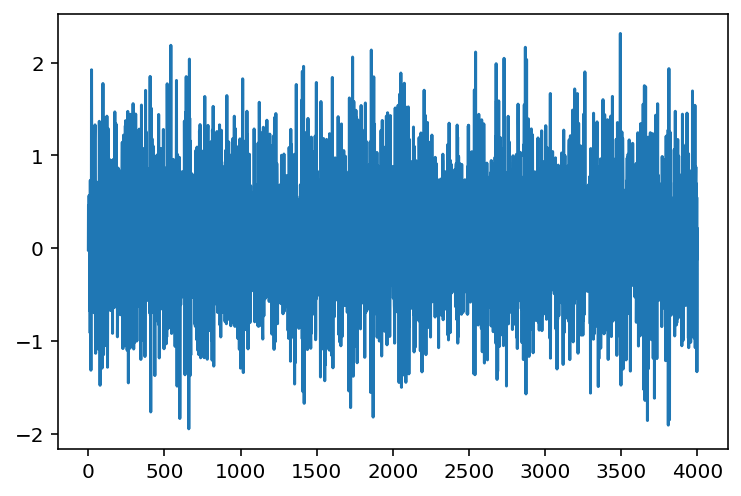

In [65]:
plt.plot(fit["user_ability"][10])

In [66]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean_ability,-0.084,0.050,-0.178,0.008,0.001,0.001,3414.0,2726.0,1.0
user_ability[0],0.317,0.748,-1.154,1.628,0.007,0.011,9990.0,3085.0,1.0
user_ability[1],0.625,0.537,-0.358,1.667,0.005,0.006,9679.0,2548.0,1.0
user_ability[2],-0.179,0.666,-1.353,1.185,0.007,0.011,10366.0,3080.0,1.0
user_ability[3],1.177,0.417,0.431,1.996,0.004,0.004,10609.0,2899.0,1.0
...,...,...,...,...,...,...,...,...,...
route_difficulty[895],-0.102,0.635,-1.322,1.077,0.008,0.011,7197.0,2924.0,1.0
route_difficulty[896],1.264,0.649,0.041,2.479,0.007,0.006,9516.0,3241.0,1.0
route_difficulty[897],1.812,0.695,0.438,3.066,0.007,0.006,9710.0,3286.0,1.0
route_difficulty[898],-1.937,0.653,-3.147,-0.720,0.007,0.006,8230.0,3022.0,1.0


In [43]:
fit_df.loc[0].head(30)

parameters
lp__              -8142.451193
accept_stat__         0.944507
stepsize__            0.191902
treedepth__           5.000000
n_leapfrog__         31.000000
divergent__           0.000000
energy__           9446.576929
mean_ability          0.015957
user_ability.1       -0.456795
user_ability.2        0.799817
user_ability.3       -0.437642
user_ability.4        0.834849
user_ability.5       -0.189158
user_ability.6        1.059988
user_ability.7        0.062242
user_ability.8       -0.653940
user_ability.9        0.261441
user_ability.10      -0.839638
user_ability.11      -0.014935
user_ability.12       0.386594
user_ability.13      -0.491337
user_ability.14      -0.808729
user_ability.15      -0.982074
user_ability.16       0.475915
user_ability.17       0.599091
user_ability.18      -0.218013
user_ability.19      -1.186964
user_ability.20       0.540749
user_ability.21      -0.117696
user_ability.22       0.868578
Name: 0, dtype: float64